# About this notebook

This notebook explores methods of integrating fire occurrence predictions with economic data in order to estimate fire risk.
The economic data available to us are the value of structures, vehicles, and structure contents for San Diego county in the years 2011 and 2019. This notebook looks at fire and economic data for the year 2011.

## Loading the fire predictions

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('darkgrid')

In [2]:
%%time
import pandas as pd
import pyarrow.parquet as pq
import s3fs
import boto3

YEAR = 2011
prediction_url = 'wildfire_capstone/logistic_regression_predictions/{}/predictions.parquet.gz/'.format(YEAR)
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
s3_keys = [item.key
           for item in s3_resource.Bucket('dse-cohort5-group5').objects.filter(Prefix=prediction_url)
           if item.key.endswith('.parquet')]
display(s3_keys[:3])
s3 = s3fs.S3FileSystem()
s3_url = 'dse-cohort5-group5/{}'
dfs = [pq.ParquetDataset(s3_url.format(key), filesystem=s3).read_pandas().to_pandas() for key in s3_keys]

['wildfire_capstone/logistic_regression_predictions/2011/predictions.parquet.gz/part-00000-4bb460d3-87f4-4d23-9d77-42b8da321003-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2011/predictions.parquet.gz/part-00002-4bb460d3-87f4-4d23-9d77-42b8da321003-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2011/predictions.parquet.gz/part-00003-4bb460d3-87f4-4d23-9d77-42b8da321003-c000.snappy.parquet']

Wall time: 44.1 s


In [3]:
num_rows = sum(len(df) for df in dfs)
num_rows

324850

In [4]:
dfs[0].head()

,date,latitude,longitude,fire_occurred,acres_burned,year,month,day,prediction
0,1311724800000000000,33.233333,-116.516667,1,13992.97,2011,07,27,1.0


In [5]:
%%time
for df in dfs:
    df.date = pd.to_datetime(df.date)
    df.prediction = df.prediction.astype('int')
    df.set_index(['date', 'latitude', 'longitude'], inplace=True)
dfs[0].head()

Wall time: 973 ms


,,,fire_occurred,acres_burned,year,month,day,prediction
date,latitude,longitude,,,,,,
2011-07-27,33.233333,-116.516667,1,13992.97,2011,07,27,1


In [6]:
complete_df = pd.concat(dfs)
print(complete_df.shape)
complete_df.head()

(324850, 6)


,,,fire_occurred,acres_burned,year,month,day,prediction
date,latitude,longitude,,,,,,
2011-07-27,33.233333,-116.516667,1,13992.97,2011,07,27,1
2011-07-25,33.316667,-116.475000,1,12388.35,2011,07,25,1
2011-07-24,33.316667,-116.516667,1,11171.95,2011,07,24,1
2011-07-26,33.316667,-116.558333,1,14275.95,2011,07,26,1
2011-10-03,33.025000,-116.516667,1,2195.53,2011,10,03,1


In [7]:
np.sum(complete_df.fire_occurred)

83

In [8]:
np.sum(complete_df.prediction)

121309

In [9]:
yearly_totals_df = complete_df.groupby(by=['latitude', 'longitude']).agg(
    total_actual_fires=pd.NamedAgg(column='fire_occurred', aggfunc='sum'),
    total_predicted_fires=pd.NamedAgg(column='prediction', aggfunc='sum'),
)
yearly_totals_df.head()

total_actual_fires  total_predicted_fires
latitude  longitude                                             
32.483333 -117.141667                   0                    211
          -117.100000                   0                    265
          -117.058333                   0                    268
          -117.016667                   0                    254
          -116.975000                   0                    238

In [10]:
yearly_totals_df.total_actual_fires.value_counts()

0    859
1     14
3      7
5      4
6      3
4      2
2      1
Name: total_actual_fires, dtype: int64

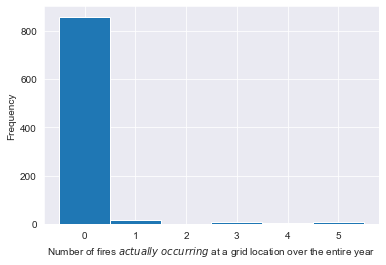

In [11]:
ax = yearly_totals_df.total_actual_fires.hist(bins=6, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{actually\ occurring}$ at a grid location over the entire year");

In [12]:
yearly_totals_df.total_predicted_fires.value_counts()

178    20
176    17
181    16
170    15
180    14
       ..
84      1
95      1
97      1
102     1
124     1
Name: total_predicted_fires, Length: 222, dtype: int64

In [13]:
np.max(yearly_totals_df.total_predicted_fires.value_counts().index)

268

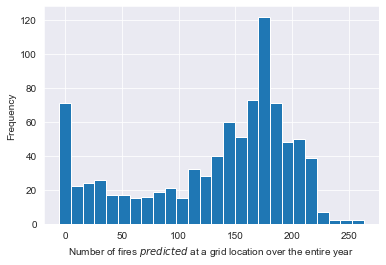

In [14]:
ax = yearly_totals_df.total_predicted_fires.hist(bins=268//10, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{predicted}$ at a grid location over the entire year");

In [15]:
yearly_totals_df['%_days_predicted_fires'] =yearly_totals_df.total_predicted_fires / 365

Pearson correlation coefficient: 0.020169678676167483


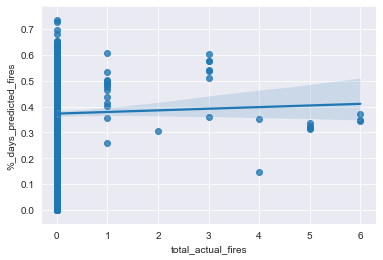

In [23]:
pearson = yearly_totals_df.loc[:, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
sns.regplot(data=yearly_totals_df, x='total_actual_fires', y='%_days_predicted_fires');

## Some observations

Unfortunately there is no real correlation between the number of predicted fires and the number of actual fires overall.
Can we get better results by restricting our attention to some particular grid locations? For example, do we get good predictions at the most valuable grid locations?

# Economic data

Let's explore the economic data a bit to determine the most valuable grid locations.

In [17]:
econ_df = pd.read_csv('grid_econ_1.csv', index_col=0)
print(econ_df.shape)
econ_df.head()

(507, 10)


,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN


In [18]:
econ_df['total_value'] = np.sum(econ_df[['Val_Struct', 'Val_Cont', 'Val_Other', 'Val_Vehic']], axis=1)
econ_df.head()

,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential,total_value
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0,2.430361e+08
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0,4.430585e+07
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0,3.829353e+08
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0,1.035808e+08
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN,4.599620e+06


(152, 11)
Pearson correlation coefficient: 0.09045281231739204


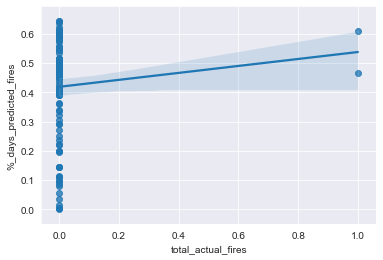

In [26]:
mask = (econ_df.total_value > econ_df.total_value.quantile(0.7))
most_valuable_locations = econ_df[mask]
print(most_valuable_locations.shape)
most_valuable_lons = most_valuable_locations.longitude
most_valuable_lats = most_valuable_locations.latitude
mask = (yearly_totals_df.reset_index().latitude.isin(most_valuable_lats) &
       yearly_totals_df.reset_index().longitude.isin(most_valuable_lons))
pearson = yearly_totals_df.reset_index().loc[mask, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
sns.regplot(data=yearly_totals_df.reset_index()[mask], x='total_actual_fires', y='%_days_predicted_fires');

## Conclusions

Even if we look at the most valuable locations, there's no real correlation between predicted fires and actual fires.
One must conclude that this model isn't sufficiently precise to be useful.